## OSWorld

In [30]:
from agential.agents.OSWorldBaseline.agent import OSWorldBaselineAgent
from agential.core.llm import LLM

In [34]:
"""
To get accessibility_tree, retreive obs by running this line
- obs, reward, done, info = env.step("pyautogui.rightClick()")
- obs["accessibility_tree"]
"""
with open("../tests/assets/osworldbaseline/accessibility_tree.txt", "r", encoding="utf-8") as file:
    accessibility_tree = file.read()

instruction = "Please help me to find the nearest restaurant."

"""
Image of screen is to be provided by user
"""
obs = {"screenshot": open("../tests/assets/osworldbaseline/output_image.jpeg", 'rb').read()}


In [35]:
agent = OSWorldBaselineAgent(
    model=LLM(model="gpt-4o"),
    observation_type="screenshot",
)

In [36]:
response, actions, messages = agent.generate(instruction, obs)

/Users/chuongnguyen/opt/anaconda3/envs/agential/lib/python3.11/site-packages/pydantic/main.py:347: UserWarning: Pydantic serializer warnings:
  Expected `CompletionTokensDetails` but got `dict` - serialized value may not be as expected
  Expected `PromptTokensDetails` but got `dict` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


Response: ```
{
  "action_type": "CLICK",
  "x": 300,
  "y": 200
}
```
Actions: [{'action_type': 'CLICK', 'x': 300, 'y': 200}]
Messages: [{'role': 'system', 'content': [{'type': 'text', 'text': 'You will act as an agent which follow my instruction and perform desktop computer tasks as instructed. You must have good knowledge of computer and good internet connection.\nFor each step, you will get an observation of an image, which is the screenshot of the computer screen. And you will predict the action of the computer based on the image.\n\nHERE is the description of the action space you need to predict, follow the format and choose the correct action type and parameters:\nACTION_SPACE = [\n    {\n        "action_type": "MOVE_TO",\n        "note": "move the cursor to the specified position",\n        "parameters": {\n            "x": {\n                "type": float,\n                "range": [0, X_MAX],\n                "optional": False,\n            },\n            "y": {\n           
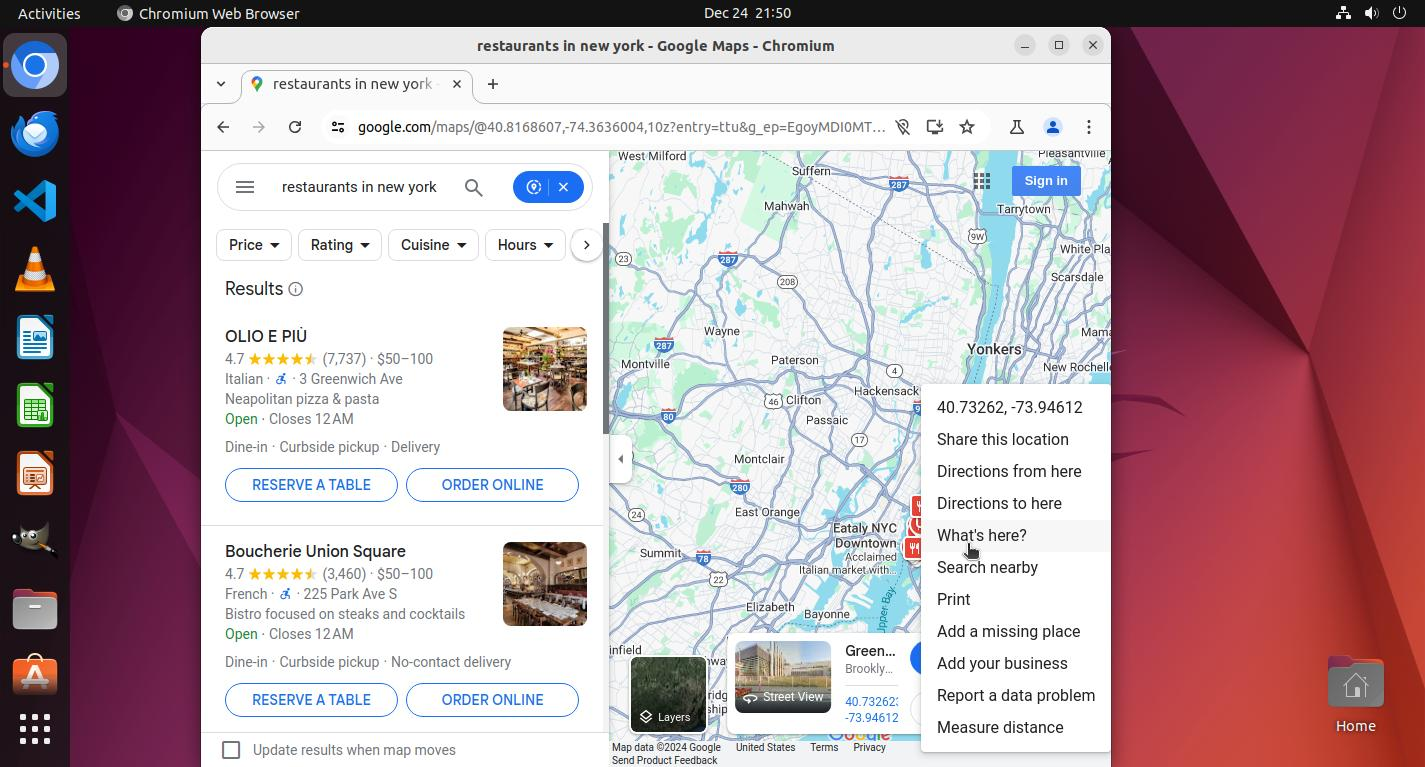

In [37]:
print(f"Response: {response}")
print(f"Actions: {actions}")
print(f"Messages: {messages}")

In [1]:
from agential.agents.OSWorldBaseline.accessibility_tree_wrap.heuristic_retrieve import (
    draw_bounding_boxes,
    filter_nodes,
    judge_node,
)

import xml.etree.ElementTree as ET

from io import BytesIO
from xml.etree.ElementTree import Element, ElementTree

state_ns_ubuntu = "https://accessibility.ubuntu.example.org/ns/state"
state_ns_windows = "https://accessibility.windows.example.org/ns/state"
component_ns_ubuntu = "https://accessibility.ubuntu.example.org/ns/component"
component_ns_windows = "https://accessibility.windows.example.org/ns/component"
value_ns_ubuntu = "https://accessibility.ubuntu.example.org/ns/value"
value_ns_windows = "https://accessibility.windows.example.org/ns/value"
class_ns_windows = "https://accessibility.windows.example.org/ns/class"

In [2]:
osworld_screenshot_path = "../tests/assets/osworldbaseline/output_image.jpeg"

In [3]:
node = Element("node")
node.attrib[f"{{{component_ns_ubuntu}}}size"] = "(1, 1)"  # Negative height
node.attrib[f"{{{component_ns_ubuntu}}}screencoord"] = "(50, 50)"  # Valid coordinates

nodes = [node]

screenshot = open(osworld_screenshot_path, "rb").read()

# coords_str = nodes[0].attrib.get("{{{:}}}screencoord".format(component_ns_ubuntu))
# size_str = nodes[0].attrib.get("{{{:}}}size".format(component_ns_ubuntu))

# coords = tuple(map(int, coords_str.strip("()").split(", ")))
# size = tuple(map(int, size_str.strip("()").split(", ")))

# bottom_right = (coords[0] + size[0], coords[1] + size[1])

# print(bottom_right[0])
# print(coords[0])
# Call the function and check for ValueError
marks, drew_nodes, element_list, tagged_screenshot = draw_bounding_boxes(
    nodes, screenshot
)

hi
